## DataFest 2022
Name: Avishek Ghosh | Team: Standard Deviants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
logs = pd.read_csv("data_files/logs.csv", low_memory=False)
logs.shape

(2106597, 132)

Our team thought of many possible questions to understand user behavior. I decided to focus on the players' skill levels over time for our analysis. Among our teams' questions, we felt that this particular question can be answered with the highest amount of data. Due to the dataset having huge numbers of null values, there would be insufficient data to investigate our other questions.

In [3]:
skills = logs[['row_id', 'player_id', 'event_time_dbl']].copy()

# compute total skill level by summing all the individual skill levels
skills['total_skill_level'] = (logs['skill_level_know'] 
                               + logs['skill_level_priority']
                               + logs['skill_level_people'] 
                               + logs['skill_level_refusal']
                               + logs['skill_level_me'])

skills = skills.dropna().reset_index(drop=True)
skills.head(10)

,row_id,player_id,event_time_dbl,total_skill_level
0,179,6427001,881,6.0
1,1430,6427001,3796,12.0
2,1861,6427001,4730,15.0
3,2429,6427001,6367,22.0
4,3200,6427001,8245,36.0
5,3394,6427001,8694,38.0
6,3957,6427001,10079,46.0
7,4605,6427001,11940,53.0
8,5001,6427001,12511,57.0
9,6017,6427001,14997,75.0


Text(0, 0.5, 'Total Skill Level')

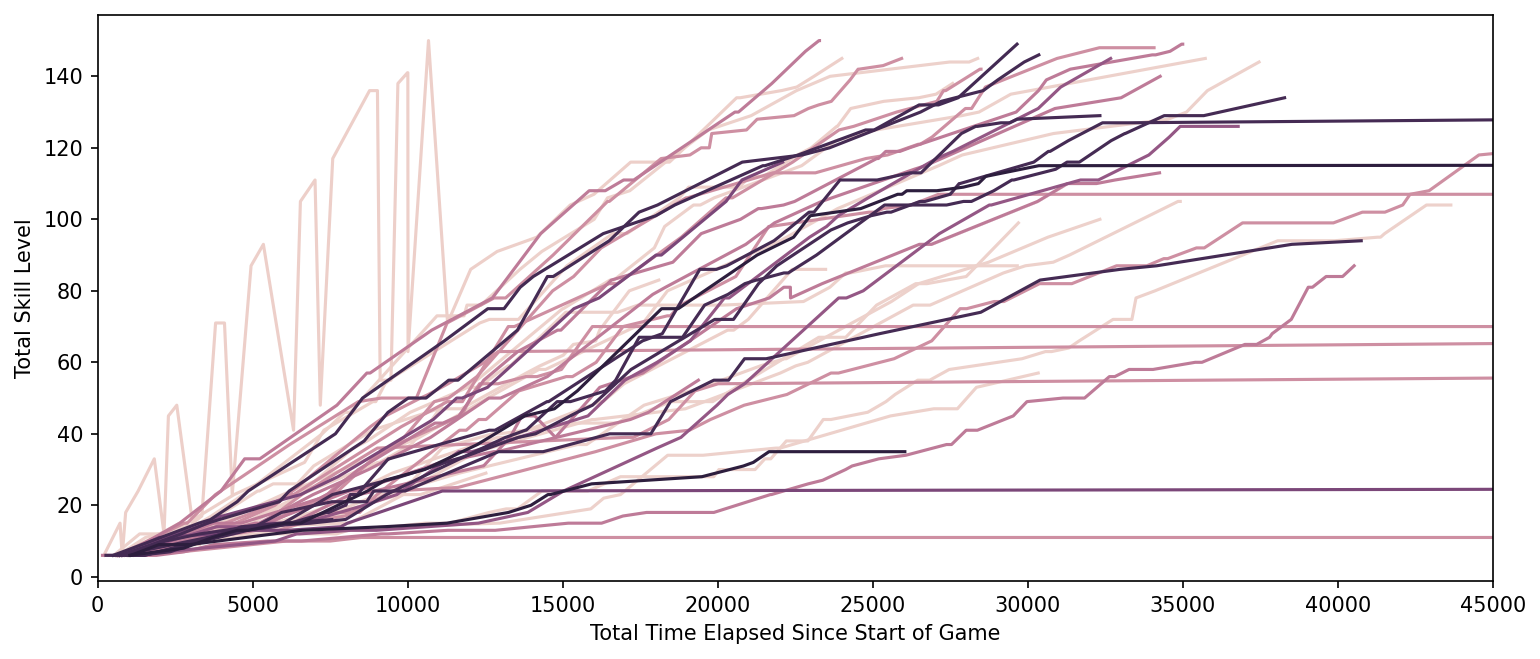

In [6]:
from random import sample
sample_data = skills[skills.player_id.isin(sample(list(skills['player_id'].unique()), 45))]

plt.figure(figsize=(12,5), dpi=150)
sns.lineplot(x = "event_time_dbl", y = "total_skill_level", hue="player_id", data=sample_data, legend=False)
plt.xlim(0, 45000)
plt.xlabel('Total Time Elapsed Since Start of Game')
plt.ylabel('Total Skill Level')

In this plot, we see the total skill level over time for each player. For some players, the total skill level stays constant for long period of time. What is the reason for that? Did the player find the game extremely difficult to progress through at some point or did they just keep the game running in another tab?

To understand this pattern, simple Linear Regression models were fitted for each player. 

In [7]:
player_ids = skills.player_id.unique()

# drop players who have very few records (<5)
player_ids = player_ids[skills.groupby('player_id')['player_id'].count() >= 5]

In [8]:
from sklearn.linear_model import LinearRegression

R_squared = {}

for player in player_ids:
    player_data = skills[skills.player_id == player].copy()
    X = player_data[['event_time_dbl']]
    y = player_data['total_skill_level']
    model = LinearRegression(fit_intercept=True).fit(X, y)
    R_squared[player] = model.score(X, y)

In [9]:
df_R2 = pd.DataFrame(R_squared.items(), columns=['player_id', 'R_square'])
df_R2

,player_id,R_square
0,6427001,0.960746
1,6427004,0.961970
2,6427005,0.993547
3,6427006,0.992611
4,6427008,0.989182
...,...,...
153,6626005,0.357499
154,6626006,0.915250
155,6626007,0.535986
156,65670031,0.993231


Text(0, 0.5, 'Total Skill Level')

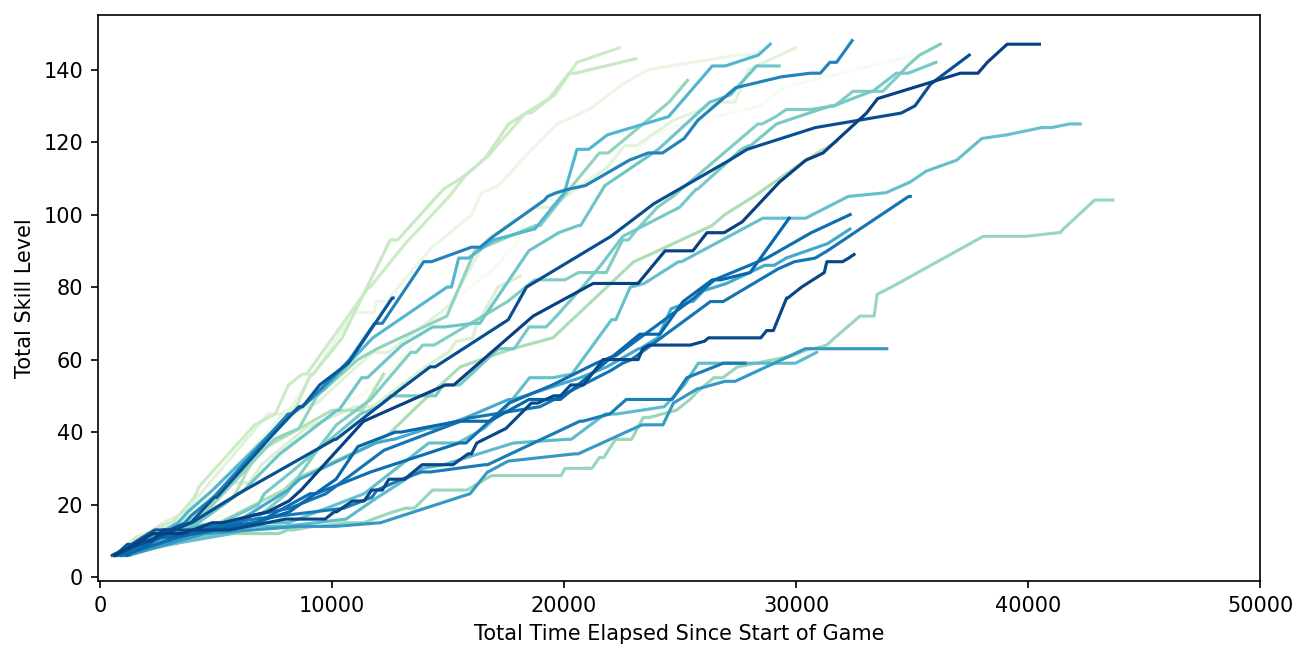

In [11]:
plt.figure(figsize=(10,5), dpi=150)
sns.lineplot(x = "event_time_dbl", y = "total_skill_level",hue="player_id", palette='GnBu',
             data=skills[skills['player_id'].isin(df_R2[df_R2['R_square'] > 0.95]['player_id'].loc[:35])], 
             legend=False)
plt.xlim(-100, 50000)
plt.xlabel('Total Time Elapsed Since Start of Game')
plt.ylabel('Total Skill Level')

Text(0, 0.5, 'Total Skill Level')

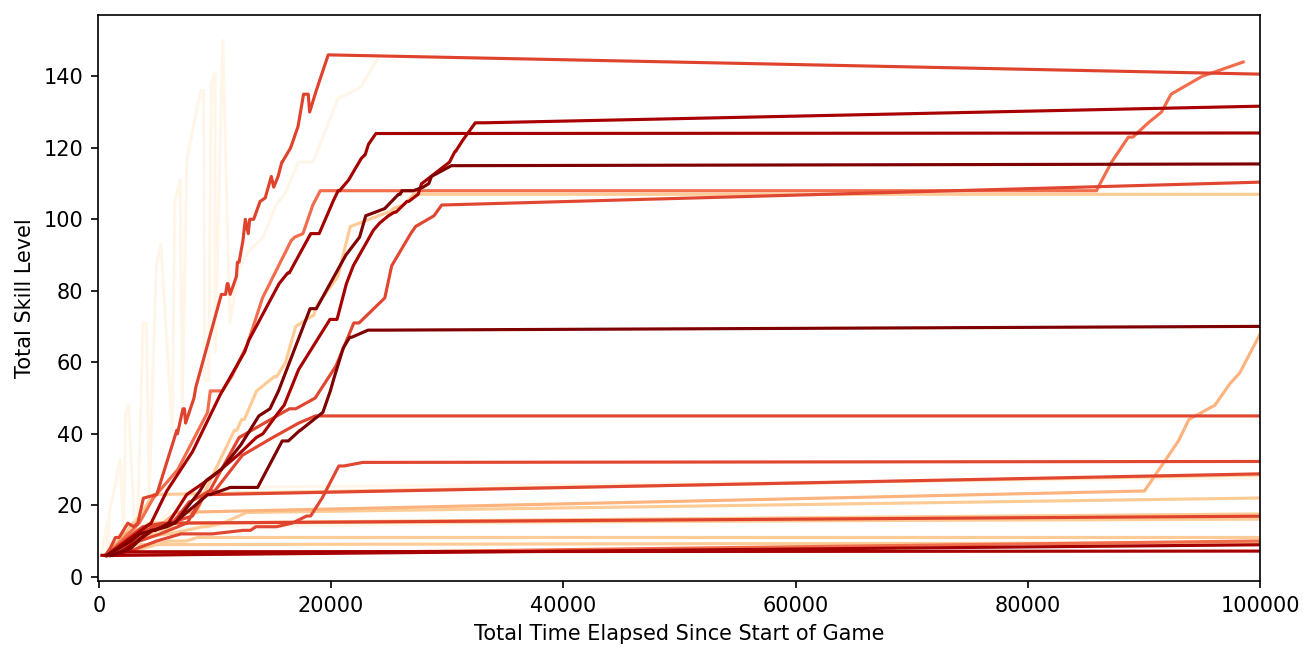

In [10]:
plt.figure(figsize=(10,5), dpi=150)
sns.lineplot(x = "event_time_dbl", y = "total_skill_level", hue="player_id", palette='OrRd',
             data=skills[skills['player_id'].isin(df_R2[df_R2['R_square'] < 0.8]['player_id'])], legend=False)
plt.xlim(-100, 100000)
plt.xlabel('Total Time Elapsed Since Start of Game')
plt.ylabel('Total Skill Level')

In this plot, we visualize the total skill level over time for players where their models had $R^2 < 0.8$. All the models with the highest error are due to the total skill level becoming constant. Let's investigate further why this is happening:

In [12]:
logs.loc[135204:135207][['row_id', 'player_id', 'date', 'session', 'event_time_dbl']]

,row_id,player_id,date,session,event_time_dbl
135204,135205,6427017,2013-07-10,Session 2,8590
135205,135206,6427017,2013-07-10,Session 2,8595
135206,135207,6427017,2013-07-15,Session 4,178291
135207,135208,6427017,2013-07-15,Session 4,178294


Here, we notice a sudden time jump! The session suddenly changed from 2 to 4, and there is a massive time increase in-between these sessions. Perhaps, the user did not log out of the game and the game continued to log time. Till we know more about how the time data is collected, we need to be extremely cautious about using time as a variable in any data analysis.

In [13]:
# DataFest Midnight Challenge 1
logs.groupby('player_id')['row_id'].size().sort_values(ascending=False).head()

player_id
6427040    28793
6567003    27896
6607005    26685
6430003    26221
6486037    23782
Name: row_id, dtype: int64

In [14]:
# DataFest Midnight challenge 2
logs.groupby('player_id')['event_time_dbl'].max().sort_values(ascending=False).head()

player_id
6607001    3032323
6607004    2610596
6486019    2184139
6626001    2167690
6567001    1807325
Name: event_time_dbl, dtype: int64